<h1><center> Metapopulation Model with SIR <br><br> 
<center> NetworkX Application<br><br> 
Wendy Shi</center></center>

# Table of Content

1. [Seeding Events](#Seeding-Events)
2. [Node Dictionary](#Node-Dictionary)
3. [US Shape File](#US-Shape-File)
4. [One simulation](#One-simulation)
5. [20 Simulation](#20-Simulation)

# Preparation

In [1]:
#Preparation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import scipy.stats as stats

# Seeding Events

In [2]:
column_names = ['S', 'E', 'I', 'R']
Seeding = pd.read_csv("../../Data/seed_1503_seed_corrected_undereporting_CDC_corrected_v3.txt",
                     delimiter=' ',
                      names=column_names)
Seeding['index'] = range(len(Seeding))
print(Seeding.shape)
Seeding.head(3)

(2327, 5)


,S,E,I,R,index
0,58877,0,0,0,0
1,233140,0,0,0,1
2,25180,0,0,0,2


In [3]:
multiplier = Seeding["S"].tolist()
multiplier[:3]

[58877, 233140, 25180]

# Node Dictionary

In [4]:
node_dict = pd.read_csv("../../Data/nodes_considered.csv")
node_dict["GEO_ID"] = node_dict["GEO_ID"].apply(lambda x: f"{int(x):05d}")
node_dict["State Code"] = node_dict["GEO_ID"].str[:2]
print(node_dict.shape)
node_dict.head(3)

(2327, 3)


,index,GEO_ID,State Code
0,0,01001,01
1,1,01003,01
2,2,01005,01


In [6]:
CA = node_dict[node_dict["State Code"] == '06']
CA_SEIR = pd.merge(CA, Seeding, on = 'index', how = 'inner')
CA_SEIR = CA_SEIR.drop(columns=['index']) #Drop the index when merging SEIR and New York GEOID

rename = {'GEO_ID' : 'GEOID'}
CA_SEIR = CA_SEIR.rename(columns = rename)

print(CA_SEIR.shape)
CA_SEIR.head(3)

(55, 6)


,GEOID,State Code,S,E,I,R
0,06001,06,1679809,35,0,0
1,06005,06,40541,0,0,0
2,06007,06,210083,0,0,0


# US Shape File

In [8]:
us_shape_file = pd.read_csv("../../Data/us_shapefile_county.csv")

us_shape_file = us_shape_file[['NAME', 'State_1', 'FIPS code', 'pop2020']].copy()
rename = {'State_1' : 'State'}
us_shape_file = us_shape_file.rename(columns = rename)

us_shape_file["FIPS code"] = us_shape_file["FIPS code"].apply(lambda x: f"{int(x):05d}")

#rename column
rename = {"FIPS code" : "GEOID"}
us_shape_file = us_shape_file.rename(columns = rename)
us_shape_file.tail(3)

,NAME,State,GEOID,pop2020
3106,Los Angeles,California,06037,9989165.0
3107,Shannon,South Dakota,46113,14309.0
3108,Bedford,Virginia,51515,6599.0


In [10]:
CA_name= us_shape_file[us_shape_file['State'] == "California"].copy()
print(NY_name.shape)
CA_name.head(3)

(58, 4)


,NAME,State,GEOID,pop2020
41,Alpine,California,06003,1198.0
185,Sierra,California,06091,3228.0
606,Modoc,California,06049,8658.0


In [11]:
CA_SEIR_name = CA_SEIR.merge(CA_name, on = 'GEOID', how = 'left')
CA_SEIR_list = CA_SEIR_name['GEOID'].tolist() #The GEOID as what is appeares in the dataframe

print(CA_SEIR_name.shape)
CA_SEIR_name.head(3)

(55, 9)


,GEOID,State Code,S,E,I,R,NAME,State,pop2020
0,06001,06,1679809,35,0,0,Alameda,California,1679844.0
1,06005,06,40541,0,0,0,Amador,California,40541.0
2,06007,06,210083,0,0,0,Butte,California,210083.0


In [17]:
CA_SEIR_name.to_excel("CA_SEIR_name.xlsx")

## Retrieve Data

In [13]:
#Original matrix for comparison
matrix = pd.read_csv("CA_Data/Aggregate/CA_ori_indi.csv")
matrix = matrix.drop(columns = 'Unnamed: 0')
matrix.head(3)

,06001,06005,06007,06009,06011,06013,06015,06017,06019,06021,...,06097,06099,06101,06103,06105,06107,06109,06111,06113,06115
0,0.760298,0.000038,0.000439,0.000013,0.000013,0.056123,0.00000,0.000299,0.000900,0.000345,...,0.005383,0.004116,0.000085,0.000017,0.0,0.001045,0.000009,0.000154,0.001113,0.000290
1,0.052792,0.158595,0.001963,0.016361,0.000000,0.039049,0.00000,0.034904,0.022251,0.000000,...,0.001091,0.074389,0.000218,0.000000,0.0,0.001309,0.000654,0.001527,0.003927,0.000000
2,0.012050,0.000030,0.821263,0.000090,0.000811,0.008985,0.00006,0.003185,0.002043,0.002404,...,0.005289,0.001472,0.010698,0.003997,0.0,0.000751,0.000661,0.000721,0.002704,0.003786


In [15]:
matrix_county_list = matrix.columns.tolist()
print(f'SEIR county list = Weight Matrix County List?: {matrix_county_list == CA_SEIR_list}') #Proceed when see Yes

array = matrix.to_numpy() #The most important step!! Turning pandas dataframe to a numpy array
array[0][0]

SEIR county list = Weight Matrix County List?: True


0.7602975487206173

# One simulation

In [18]:
def stochastic_SIR(y, l, array):
    
    # y is the list that contains the initial condition of S_i, I_i, R_i
    S = y[:l]  # a five element list
    E = y[l:l+l]
    I = y[l+l:l+l+l]  # a five element list
    R = y[l+l+l:]  # the rest elements
    
    t = 0
    time_series = [(t, S.copy(), E.copy(), I.copy(), R.copy())]
    
    #l = len(S)
    
    # Define each element of N
    N = [S[i] + E[i] + I[i] + R[i] for i in range(l)]
    
    # Define N_hat
    N_hat = [array[i][i] * N[i] for i in range(l)]
    for i in range(l):
        for j in range(l):
            if i != j:
                N_hat[i] += array[j][i] * N[j]
    
    #print(N_hat)
    
    # Run the loop ------------------------------------
    t_max = 50
    #while any(i > 0 for i in I) and t < t_max: #time stamp loop--
    while t < t_max:
        
        #Define value for beta
        if t < 25: 
            beta = 3.5
        else: 
            beta = 1.7
        
        for i in range(l): #node loop------
            
            # Define I_hat for all nodes
            I_hat = [array[i][i] * I[i] for i in range(l)]
            for j in range(l):
                if i != j:
                    I_hat[i] += array[j][i] * I[j]
            
            # Calculate lambda
            lmda = beta * (array[i][i] ** 2) * I[i] / N_hat[i]
            for j in range(l):
                if i != j:
                    lmda += (beta * array[i][i] * array[j][i] * I[j] / N_hat[i]) + (beta * array[i][j] * I_hat[j] / N_hat[j])
            
            #Newly added term, having b equals to 3.5 and largrer sample of nodes makes lamda larger than 1
            lmda_new = min(lmda,1)
            
            #Check again to see if you can improve the model-------------
            new_exposed = np.random.binomial(S[i], lmda_new)*1
            new_infected = np.random.binomial(E[i], 0.2703)*1
            new_recovered = np.random.binomial(I[i], 0.2448)*1 
            
            # Update S, I, R for node i
            S[i] -= new_exposed
            E[i] += new_exposed - new_infected
            I[i] += new_infected - new_recovered
            R[i] += new_recovered
        
        # Store the results (make copies to avoid overwriting)
        time_series.append((t, S.copy(), E.copy(), I.copy(), R.copy()))
        
        # Increment time (optional)
        t += 1
        #print(f"Time: {t}, S: {S}, I: {I}, R: {R}")
        if t % 10 == 0:
            print(t)
    
    return time_series

# Applying for the function

In [12]:
#NY_SEIR = pd.read_excel("NY_SEIR.xlsx")
#NY_SEIR = NY_SEIR.drop(columns = 'Unnamed: 0')
#NY_SEIR.iloc[15:20]

In [20]:
#Define initial condition
S0 = CA_SEIR["S"].tolist()  
E0 = CA_SEIR["E"].tolist()  
I0 = CA_SEIR["I"].tolist()   
R0 = CA_SEIR["R"].tolist()
initial_conditions = S0 + E0 + I0 + R0 #this is the y (?): Yup!
print(len(S0),len(E0),len(I0), len(R0))

55 55 55 55


In [21]:
#first simulation
time_series = stochastic_SIR(initial_conditions, 55, array)

10
20
30
40
50


In [22]:
times, S_values, E_values, I_values, R_values = zip(*time_series)

S_list = list(zip(*S_values))
for i, S in enumerate(S_list):
    globals()[f'S{i}'] = S
    
E_list = list(zip(*E_values))
for i, E in enumerate(E_list):
    globals()[f'E{i}'] = E
    
I_list = list(zip(*I_values))
for i, I in enumerate(I_list):
    globals()[f'I{i}'] = I
    
R_list = list(zip(*R_values))
for i, R in enumerate(R_list):
    globals()[f'R{i}'] = R

<br>

- **globals()** is a built-in function in Python that returns a dictionary representing the current global symbol table. The global symbol table contains all the global variables in the program. When you do globals()[f'S{i}'] = s, you're dynamically creating a new global variable with a name like S1, S2, etc., and assigning it the value s. In this case, f'S{i}' generates the variable name as a string, and s is the corresponding value from the list.

<br>

- **enumerate()** is a built-in Python function that allows you to loop over an iterable (like a list, tuple, or string) while also keeping track of the index of each element.When used like enumerate(S_list, start=1), it returns pairs of (index, value), where index starts at 1 and increases by 1 for each iteration, while value is the corresponding item from the list. The start=1 parameter means that the counting will begin at 1 instead of the default 0.

# Visualization: One Loop

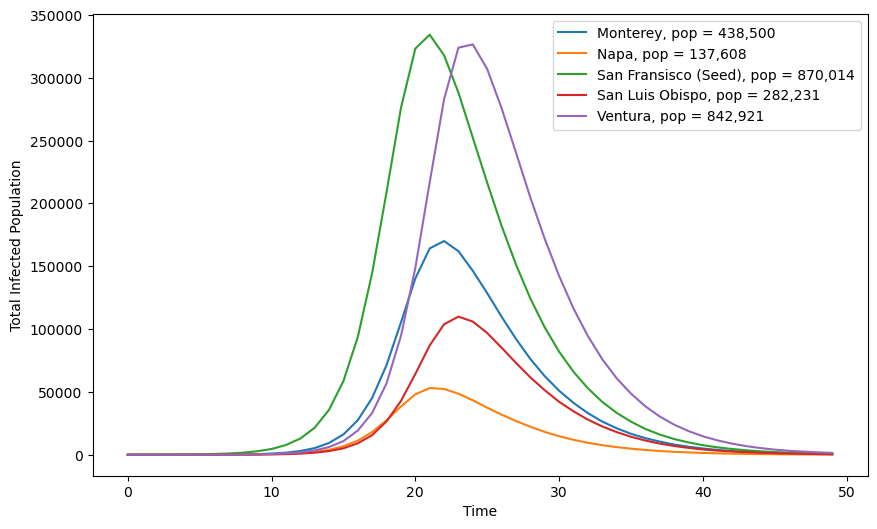

In [24]:
plt.figure(figsize=(10,6))

plt.plot(times, I24, label='Monterey, pop = 438,500')
plt.plot(times, I25, label='Napa, pop = 137,608')
plt.plot(times, I35, label='San Fransisco (Seed), pop = 870,014')
plt.plot(times, I37, label='San Luis Obispo, pop = 282,231')
plt.plot(times, I52, label='Ventura, pop = 842,921')

plt.xlabel('Time')
plt.ylabel('Total Infected Population')
plt.legend()
#plt.savefig("CA_SEIR_Example.png", dpi=300, bbox_inches='tight')

plt.show()



# 20 Simulation

In [73]:
matrix = pd.read_csv("CA_Data/Aggregate/CA_P001_agg.csv")
matrix = matrix.drop(columns = 'Unnamed: 0')
matrix.head(3)

array = matrix.to_numpy() #The most important step!! Turning pandas dataframe to a numpy array
array[0][0]

0.1961192856571942

In [74]:
all_simulations = []

for sim in range(20):
    
    S0 = NY_SEIR["S"].tolist()  
    E0 = NY_SEIR["E"].tolist()  
    I0 = NY_SEIR["I"].tolist()   
    R0 = NY_SEIR["R"].tolist()
    initial_conditions = S0 + E0 + I0 + R0 #this is the y (?): Yup!

    result = stochastic_SIR(initial_conditions, 55, array)
    print("Simulation", sim, "Finished!!!-------------------------------")
    
    all_simulations.append(result)

10
20
30
40
50
Simulation 0 Finished!!!-------------------------------
10
20
30
40
50
Simulation 1 Finished!!!-------------------------------
10
20
30
40
50
Simulation 2 Finished!!!-------------------------------
10
20
30
40
50
Simulation 3 Finished!!!-------------------------------
10
20
30
40
50
Simulation 4 Finished!!!-------------------------------
10
20
30
40
50
Simulation 5 Finished!!!-------------------------------
10
20
30
40
50
Simulation 6 Finished!!!-------------------------------
10
20
30
40
50
Simulation 7 Finished!!!-------------------------------
10
20
30
40
50
Simulation 8 Finished!!!-------------------------------
10
20
30
40
50
Simulation 9 Finished!!!-------------------------------
10
20
30
40
50
Simulation 10 Finished!!!-------------------------------
10
20
30
40
50
Simulation 11 Finished!!!-------------------------------
10
20
30
40
50
Simulation 12 Finished!!!-------------------------------
10
20
30
40
50
Simulation 13 Finished!!!-------------------------------
10

In [75]:
import pickle

with open('20_simulations_P001_CA_agg.pkl', 'wb') as f:
    pickle.dump(all_simulations, f)